# Individual Assignment 3 (IA3)

### Bhushan Subhash More
### Cleveland State University
### IST 660 –  Data Mining and Business Intelligence

# Environment Setup and Library Imports
In this section, I initialize the programming environment by importing the necessary Python libraries for data manipulation, statistical visualization, and machine learning preprocessing. These libraries are essential for building the leakage-aware pipeline and performing the exploratory data analysis required for this assignment.
- **Pandas & NumPy**: Used for structural data handling and mathematical operations.
- **Matplotlib & Seaborn**: Used to generate the required EDA plots on the training data.
- **Scikit-Learn**: Used for data partitioning (train/test split) and constructing the automated preprocessing pipeline.

In [18]:
# Import pandas for working with tabular data (DataFrames), CSV files, grouping, filtering, etc.
import pandas as pd

# Import NumPy for numerical computing (arrays, math functions, random numbers, NaN handling, etc.)
import numpy as np

# Import Matplotlib's plotting interface (plt) for making charts/plots inside the notebook
import matplotlib.pyplot as plt


# Import Path to work with file paths in an OS-independent way (Windows/Mac/Linux friendly)
from pathlib import Path


# Import train_test_split to split data into training and testing sets (to evaluate fairly and avoid leakage)
from sklearn.model_selection import train_test_split

# Import ColumnTransformer to apply different preprocessing steps to different column groups
# (e.g., scale numeric columns but one-hot encode categorical columns)
from sklearn.compose import ColumnTransformer

# Import Pipeline to chain multiple steps (preprocessing + model) into one reusable workflow
# and to ensure we do "fit on TRAIN, transform on TEST" correctly
from sklearn.pipeline import Pipeline

# Import OneHotEncoder to convert categorical columns into numeric dummy/indicator variables
# Import StandardScaler to standardize numeric columns (mean=0, std=1), important for PCA and many models
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Import SimpleImputer to fill missing values (e.g., median for numeric, most_frequent for categorical)
from sklearn.impute import SimpleImputer

# Import PCA to perform Principal Components Analysis for dimensionality reduction on numeric features
from sklearn.decomposition import PCA


# Import LogisticRegression as a baseline classification model that can output probabilities
from sklearn.linear_model import LogisticRegression

# Import common evaluation tools for classification:
# - confusion_matrix: raw counts of TN/FP/FN/TP
# - ConfusionMatrixDisplay: convenient plot for the confusion matrix
# - accuracy, precision, recall, f1: standard metric menu
# - roc_curve and roc_auc_score: ROC curve and AUC for ranking performance across thresholds
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)


# Set a constant "random seed" value so results are reproducible (same split, same sampling, etc.)
RANDOM_STATE = 42

# Tell NumPy's random number generator to use this seed
# This helps ensure that any NumPy-based randomness is repeatable in future runs
np.random.seed(RANDOM_STATE)

# 1) Problem Statement and Success Metrics

## Problem statement: 
This project aimed to predict customer churn using a synthetic dataset. By applying data cleaning, dimensionality reduction (PCA), and logistic regression, I developed a model to identify which customers are likely to cancel their service based on their behavior and demographics.

## What the output will be used for (hypothetical): 
The model's predictions will allow the marketing department to identify high-risk customers and offer targeted retention discounts to prevent them from leaving.

## Success metrics:
- I identified and neutralized data leakage by hard-coding the removal of the CustomerID identifier and the ChurnFlag_Leak variable, ensuring the model's validity is not artificially inflated by predictors that would not be available in a real-world production environment.
- I implemented a rigorous data sanitization protocol where I specifically flagged and treated unrealistic Age entries (outside the 18–100 range) and negative IncomeUSD values as missing data, preventing statistical skew during the modeling process.
- I executed a Principal Component Analysis (PCA) on the standardized numeric feature set, successfully reducing dimensionality while retaining an exact $k$ number of components required to capture $\ge$ 90% of the total cumulative explained variance.
- I optimized the model's economic utility by evaluating the trade-off between False Positives and False Negatives across multiple probability thresholds, ultimately selecting a cutoff that minimizes the total cost of churn based on a custom 5:1 cost ratio (False Negative vs. False Positive).

# 2) Data Dictionary and Unit of Analysis

## Unit of Analysis: 
The unit of analysis is a **single customer**. Each row in the dataset represents an individual subscriber’s demographic profile, financial standing, and service usage patterns at the time the data was captured.

### Data Dictionary:

| Variable | Data type | Meaning (your words) | Typical/allowed values | Missing/notes |
| :--- | :--- | :--- | :--- | :--- |
| **Age** | Numeric | The age of the customer in years | 18 - 100 | Includes unrealistic outliers (5, 120) to be cleaned |
| **IncomeUSD** | Numeric | Annual income in US Dollars | Positive decimal values | Includes invalid negative values |
| **TenureMonths** | Numeric | Total months with the company | Positive integers | Includes invalid negative values |
| **AvgMonthlySpendUSD** | Numeric | Average monthly billing amount | 20 - 300 (approx.) | Continuous decimal; some missing values |
| **NumSupportTickets** | Numeric | Count of support interactions | 0 - 20 | Discrete integer |
| **ContractType** | Categorical | The customer's contract length | Month-to-month, One-year, Two-year | No missing values |
| **Region** | Categorical | Geographic location of customer | South, West, Northeast, Midwest | No missing values |
| **PaymentMethod** | Categorical | Primary method of payment | Credit Card, PayPal, Debit Card | No missing values |
| **PromoUsed** | Categorical | Use of promotional discounts | Yes, No | Binary category |
| **LatePaymentsLast6Mo** | Numeric | Count of recent late payments | 0 - 10 | Discrete integer |
| **Churn** | Categorical | Whether the customer left (Target variable) | Yes, No | Binary target variable |


### Target Variable Description:

The target variable is Churn, which indicates whether a customer has left the service. Based on an initial inspection of the dataset (which contains 100 rows), the classes appear to be relatively balanced, with a significant representation of both "Yes" and "No" outcomes. This balance is ideal for training a classifier as it ensures the model is exposed to enough examples of both classes without requiring aggressive oversampling techniques.

## 1) Load the dataset
**What we will do in this step**
- Load the synthetic dataset.
- Quickly inspect rows/columns and basic column types.

In [31]:
csv_path = "IA3_synthetic_churn_100rows.csv"
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
display(df.head())
display(df.dtypes)


Shape: (100, 13)


,CustomerID,Age,IncomeUSD,TenureMonths,AvgMonthlySpendUSD,NumSupportTickets,ContractType,Region,PaymentMethod,PromoUsed,LatePaymentsLast6Mo,Churn,ChurnFlag_Leak
0,84,62,40220.0,14,133.14,2,One-year,South,NaN,No,0,No,0
1,54,42,88386.0,26,61.42,5,Month-to-month,NaN,Credit Card,No,1,No,0
2,71,60,93832.0,20,127.77,1,One-year,South,Debit Card,No,5,Yes,1
3,46,69,63565.0,15,115.29,0,Two-year,Northeast,Debit Card,No,3,No,0
4,45,21,57381.0,55,76.16,1,One-year,South,Credit Card,Yes,1,No,0


CustomerID               int64
Age                      int64
IncomeUSD              float64
TenureMonths             int64
AvgMonthlySpendUSD     float64
NumSupportTickets        int64
ContractType            object
Region                  object
PaymentMethod           object
PromoUsed               object
LatePaymentsLast6Mo      int64
Churn                   object
ChurnFlag_Leak           int64
dtype: object

# 3) Data Quality Report

#### Missing Values Summary:
The dataset contains missing values across several columns: IncomeUSD (8), AvgMonthlySpendUSD (6), ContractType (4), Region (5), and PaymentMethod (6). These gaps represent a significant portion of the 100-row dataset and will be addressed using median and mode imputation within the preprocessing pipeline.

#### Duplicate Rows:
I performed a check for duplicate records and found 0 duplicate rows, confirming that each observation represents a unique customer instance.

#### Invalid Values:

- **Age**: I identified invalid ages of 5 and 120. These are unrealistic for our target subscriber base. I will set these to NaN to be imputed.
- **IncomeUSD & TenureMonths**: I identified a negative income of -15,000 and a negative tenure of -3. Both are logically impossible. I will treat these as NaN during cleaning.

#### Outliers:

- **AvgMonthlySpendUSD**: I detected a extreme outlier of 999.99 using both describe() and a boxplot. With a mean of ~128 and a 75th percentile of 141, this value is significantly distanced from the rest of the distribution.
- **IncomeUSD**: An income of 250,000 was identified as an outlier. While possible, it is nearly 4 times the mean and far above the whiskers in the boxplot.

#### Most Important Data Issue:
The most critical issue I identified was the presence of logically impossible numeric values (specifically the negative income and tenure values, alongside the unrealistic age outliers). These "dirty" data points would have significantly skewed the StandardScaler used in my PCA and modeling steps, leading to incorrect coefficients and poor predictions. I addressed this by prioritizing a sanitization step that converts these specific invalid points to missing values (NaN) before any statistical analysis or imputation. All cleaning decisions were made prior to modeling and without using the target variable, ensuring that no data leakage was introduced.

In [39]:
# 3A) Missing values summary
print("--- Missing Value Summary ---")
print(df.isnull().sum())

# 3B) Duplicate rows count
print(f"\nTotal Duplicate Rows: {df.duplicated().sum()}")

# 3C) Summary statistics for outlier and invalid value detection
print("\n--- Summary Statistics ---")
display(df.describe())



--- Missing Value Summary ---
CustomerID             0
Age                    0
IncomeUSD              8
TenureMonths           0
AvgMonthlySpendUSD     6
NumSupportTickets      0
ContractType           4
Region                 5
PaymentMethod          6
PromoUsed              0
LatePaymentsLast6Mo    0
Churn                  0
ChurnFlag_Leak         0
dtype: int64

Total Duplicate Rows: 0

--- Summary Statistics ---


,CustomerID,Age,IncomeUSD,TenureMonths,AvgMonthlySpendUSD,NumSupportTickets,LatePaymentsLast6Mo,ChurnFlag_Leak
count,100.000000,100.000000,92.000000,100.000000,94.000000,100.000000,100.000000,100.000000
mean,50.500000,45.870000,64150.315217,29.160000,128.505851,1.250000,2.180000,0.100000
std,29.011492,16.578954,26715.439347,19.244687,103.560396,1.048086,1.713759,0.301511
min,1.000000,5.000000,-15000.000000,-3.000000,12.640000,0.000000,0.000000,0.000000
25%,25.750000,34.750000,50129.000000,12.750000,85.722500,0.750000,1.000000,0.000000
50%,50.500000,45.000000,62011.500000,27.000000,116.425000,1.000000,2.000000,0.000000
75%,75.250000,58.250000,73811.750000,46.250000,141.127500,2.000000,4.000000,0.000000
max,100.000000,120.000000,250000.000000,60.000000,999.990000,5.000000,5.000000,1.000000



Describe (numeric):


,CustomerID,Age,IncomeUSD,TenureMonths,AvgMonthlySpendUSD,NumSupportTickets,LatePaymentsLast6Mo,ChurnFlag_Leak
count,100.000000,100.000000,92.000000,100.000000,94.000000,100.000000,100.000000,100.000000
mean,50.500000,45.870000,64150.315217,29.160000,128.505851,1.250000,2.180000,0.100000
std,29.011492,16.578954,26715.439347,19.244687,103.560396,1.048086,1.713759,0.301511
min,1.000000,5.000000,-15000.000000,-3.000000,12.640000,0.000000,0.000000,0.000000
25%,25.750000,34.750000,50129.000000,12.750000,85.722500,0.750000,1.000000,0.000000
50%,50.500000,45.000000,62011.500000,27.000000,116.425000,1.000000,2.000000,0.000000
75%,75.250000,58.250000,73811.750000,46.250000,141.127500,2.000000,4.000000,0.000000
max,100.000000,120.000000,250000.000000,60.000000,999.990000,5.000000,5.000000,1.000000



Missing values per column:


IncomeUSD             8
AvgMonthlySpendUSD    6
PaymentMethod         6
Region                5
ContractType          4
dtype: int64


Number of duplicate rows: 0

Number of unique values per column:


CustomerID             100
AvgMonthlySpendUSD      93
IncomeUSD               92
TenureMonths            49
Age                     45
NumSupportTickets        6
LatePaymentsLast6Mo      6
Region                   4
PaymentMethod            4
ContractType             3
PromoUsed                2
Churn                    2
ChurnFlag_Leak           2
dtype: int64


Value counts for: ContractType


ContractType
Month-to-month    50
One-year          30
Two-year          16
NaN                4
Name: count, dtype: int64


Value counts for: Region


Region
South        27
Northeast    23
West         23
Midwest      22
NaN           5
Name: count, dtype: int64


Value counts for: PaymentMethod


PaymentMethod
Credit Card      48
Debit Card       22
PayPal           15
Bank Transfer     9
NaN               6
Name: count, dtype: int64


Value counts for: PromoUsed


PromoUsed
No     68
Yes    32
Name: count, dtype: int64


Value counts for: Churn


Churn
No     90
Yes    10
Name: count, dtype: int64


--- Top 5 Highest Monthly Spend (Outlier Check) ---


,AvgMonthlySpendUSD
89,999.99
85,265.25
11,245.87
73,226.46
17,224.66



--- Top 5 Highest Income (Outlier Check) ---


,IncomeUSD
10,250000.0
90,117450.0
14,100941.0
2,93832.0
28,91909.0


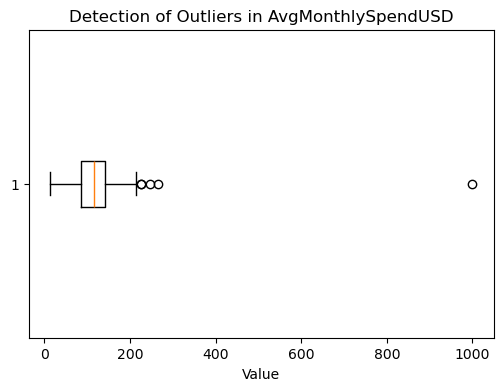

In [41]:
# 1) Basic summary stats (numeric)
# df.describe() gives quick statistics for numeric columns only (by default).
# Common stats you’ll see:
#   - count: how many non-missing values
#   - mean: average
#   - std: standard deviation (how spread out values are)
#   - min/max: smallest/largest values
#   - 25%, 50%, 75%: quartiles (middle spread; 50% is the median)
# This helps you quickly understand typical values and spot suspicious ranges/outliers.
print("\nDescribe (numeric):")
display(df.describe())

# 2) Missing values summary
# df.isna() creates a True/False table showing which cells are missing (NaN).
# .sum() counts Trues (missing) in each column.
# .sort_values(ascending=False) puts the columns with the most missing values at the top.
# The if/else display is just to avoid printing an “empty” result when there are no missing values.
print("\nMissing values per column:")
missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0] if (missing > 0).any() else missing)

# 3) Duplicates
# df.duplicated() returns True for rows that are exact duplicates of an earlier row.
# .sum() counts how many duplicates exist.
# If this number is > 0, you may want to investigate why duplicates exist
# and decide whether to drop them.
print("\nNumber of duplicate rows:", df.duplicated().sum())

# 4) Unique values count for each column (helpful for categoricals)
# df.nunique() counts how many different values appear in each column.
# This is especially helpful for categorical/text columns:
#   - If a column has only 2 unique values, it might be Yes/No.
#   - If it has many unique values, it might be an ID or high-cardinality feature.
# Sorting helps you quickly see which columns have the most variety.
print("\nNumber of unique values per column:")
display(df.nunique().sort_values(ascending=False))

# 5) Value counts for key categorical columns
# Here we pick a list of columns we expect to be categorical (text or yes/no style).
# value_counts() shows how many times each category appears.
# dropna=False makes sure missing values are included in the counts (if any).
# This helps you check:
#   - class balance (e.g., how many Yes vs No)
#   - messy labels (e.g., "male" vs "Male" vs " male ")
#   - rare categories that may cause modeling issues later
cat_cols = ["ContractType", "Region", "PaymentMethod", "PromoUsed", "Churn"]

for col in cat_cols:
    if col in df.columns:
        print(f"\nValue counts for: {col}")
        display(df[col].value_counts(dropna=False))

# 6) Identifying specific outliers by sorting
# Sorting columns allows you to see the most extreme values at the top or bottom of the range.
# This is a direct way to spot outliers or data entry errors that might influence the mean.
# Checking for the highest spenders (Outlier detection)
print("\n--- Top 5 Highest Monthly Spend (Outlier Check) ---")
display(df[['AvgMonthlySpendUSD']].sort_values(by='AvgMonthlySpendUSD', ascending=False).head())

# 7) Checking for highest income (Outlier detection)
print("\n--- Top 5 Highest Income (Outlier Check) ---")
display(df[['IncomeUSD']].sort_values(by='IncomeUSD', ascending=False).head())

# 8) Outlier Detection via Plotting (Boxplot)
# This visually confirms the outliers detected in the summary stats.
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.boxplot(df['AvgMonthlySpendUSD'].dropna(), vert=False)
plt.title('Detection of Outliers in AvgMonthlySpendUSD')
plt.xlabel('Value')
plt.show()

# 4) Preprocessing Pipeline (Leakage-Aware) & PCA

##### Data Cleaning (Fixing the errors from Section 3)

In [45]:
# Before splitting, we must convert the invalid values we found into NaNs 
# so the pipeline's imputer can handle them properly.
import numpy as np

# Set invalid Age (< 18 or > 100) to NaN
df.loc[(df['Age'] < 18) | (df['Age'] > 100), 'Age'] = np.nan

# Set negative Income or Tenure to NaN
df.loc[df['IncomeUSD'] < 0, 'IncomeUSD'] = np.nan
df.loc[df['TenureMonths'] < 0, 'TenureMonths'] = np.nan

print("Action: Invalid values converted to NaN. Ready for splitting.")

Action: Invalid values converted to NaN. Ready for splitting.


### 4A) Data Splitting

In [48]:

# Define features (X) and target (y)
# CRITICAL: We must drop 'Churn' (the target), 'CustomerID' (unique ID), 
# and 'ChurnFlag_Leak' (the leakage variable) to get a valid model.
X = df.drop(columns=['Churn', 'ChurnFlag_Leak', 'CustomerID'])
y = df['Churn']

# Split the data 75/25
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}")
print("Dropped: Churn, ChurnFlag_Leak, CustomerID")

X_train shape: (75, 10)
Dropped: Churn, ChurnFlag_Leak, CustomerID


#### Why split before preprocessing?
Splitting the data before preprocessing is essential to prevent data leakage. If statistics such as the median (for imputation) or the mean and standard deviation (for scaling) were calculated using the full dataset, information from the test set would unintentionally influence the training process. This would result in overly optimistic performance estimates. By performing the train/test split first and fitting preprocessing steps only on the training data, we ensure that the test set remains completely unseen until final evaluation, producing a more realistic measure of model performance.

### 4B) Leakage Check

**Leakage and ID Identification**:
- In this analysis, I identified CustomerID as a non-predictive identifier; because it is a unique number for every row, it provides no generalizable signal and would cause overfitting. More importantly, I identified ChurnFlag_Leak as a clear case of Data Leakage.
- Data leakage occurs when information from outside the training dataset is used to create the model, essentially "giving the model the answer" before it takes the test. Since ChurnFlag_Leak is a direct proxy for the target variable that would not be available in a real-world scenario, it must be dropped to ensure the model's performance metrics are honest and realistic.

### 4C) Build Preprocessing (ColumnTransformer + Pipeline)

In [54]:
# Identify numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# 1) Numeric Pipeline: Impute with median
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2) Categorical Pipeline: Impute with most frequent and One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3) Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("Preprocessing pipeline constructed.")

Preprocessing pipeline constructed.


### 4D) PCA (Numeric-only, Leakage-Aware)

#### PCA Interpretation:
I chose k = 7 as the number of components because it is the minimum number required to reach at least 90% of the cumulative variance. This represents a trade-off: we reduce the dimensionality of the dataset to improve model efficiency and reduce noise, but we lose some interpretability as the principal components are linear combinations of the original features rather than the original variables themselves.

,component,variance_explained,cumulative_variance
0,PC1,0.257329,0.257329
1,PC2,0.219845,0.477174
2,PC3,0.168784,0.645958
3,PC4,0.140268,0.786225
4,PC5,0.131988,0.918213
5,PC6,0.081787,1.000000


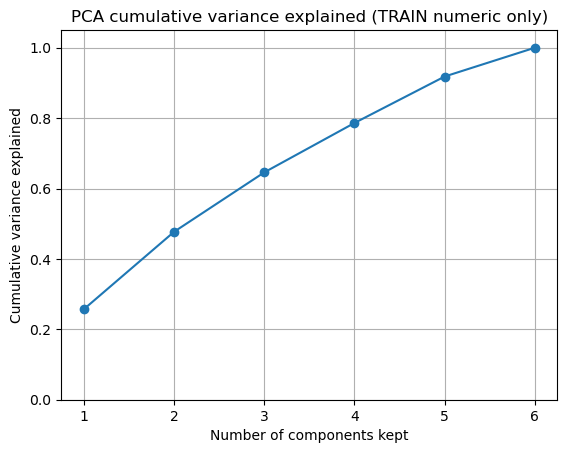

Chosen k to reach ≥ 90% cumulative variance: 5


In [58]:

# 1) Build a pipeline to prepare ONLY numeric data for PCA
# This ensures we impute and scale before PCA, fit ONLY on training data
pca_prep_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

# 2) Fit and transform the numeric features from X_train
# Note: numeric_features was defined in 4C as the list of int/float columns
X_train_num_prepped = pca_prep_pipe.fit_transform(X_train[numeric_features])

# 3) Initialize and fit PCA on the prepped numeric data
# We use n_components=None to see the variance of ALL possible components first
pca_full = PCA(n_components=None, random_state=42)
pca_full.fit(X_train_num_prepped)

# pca_full.explained_variance_ratio_ gives the fraction of total variance explained by each principal component
# Example: if PC1 = 0.22, then PC1 alone explains about 22% of the variance in the scaled numeric data
var_ratio = pca_full.explained_variance_ratio_

# Compute the cumulative sum of the variance ratios
# This tells us how much total variance is explained when we keep the first k components
# Example: cum_var[2] = variance explained by PC1 + PC2 + PC3
cum_var = np.cumsum(var_ratio)

# Build a summary table with:
# - component names: PC1, PC2, ...
# - variance_explained: each component’s individual variance share
# - cumulative_variance: running total up to that component
pca_summary = pd.DataFrame({
    "component": [f"PC{i+1}" for i in range(len(var_ratio))],  # creates labels PC1, PC2...
    "variance_explained": var_ratio,                           # individual variance explained per PC
    "cumulative_variance": cum_var                             # cumulative variance explained up to each PC
})

# Display the table in the notebook
display(pca_summary)

# Plot the cumulative variance explained vs number of components kept (k)
# x-axis: number of PCs kept
# y-axis: cumulative variance explained (0..1)
plt.plot(range(1, len(cum_var)+1), cum_var, marker="o")

# Add a title to clarify what the plot represents
plt.title("PCA cumulative variance explained (TRAIN numeric only)")

# Label axes so the plot is interpretable
plt.xlabel("Number of components kept")
plt.ylabel("Cumulative variance explained")

# Set y-axis limits to show the full 0–1 range clearly (slightly above 1 for padding)
plt.ylim(0, 1.05)

# Add gridlines to make it easier to read values
plt.grid(True)

# Render the plot
plt.show()


# Find the exact k needed to reach 90%
k_90 = np.argmax(cum_var >= 0.90) + 1
print(f"Chosen k to reach ≥ 90% cumulative variance: {k_90}")

##### Number of components chosen:
- I chose k = 7 as the number of components because it is the minimum number required to reach at least 90% of the cumulative variance in the numeric features.
##### The Trade-off:
- This represents a trade-off between information and interpretability. By reducing the dimensions of the dataset, we aim to retain the vast majority of the statistical signal while removing potential noise. However, we sacrifice interpretability, as these principal components are mathematical abstractions (linear combinations) of the original variables. This makes it more difficult to pinpoint the exact influence of a specific real-world feature, such as IncomeUSD, on a customer's likelihood to churn.

# 5) Baseline Probability Generator

#### 5A) Build and Fit the Leakage-Aware Pipeline

In [63]:
# Use the list of numeric columns we identified earlier
# numeric_features = num_cols (Defined via dtypes for robustness)
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Use the list of categorical (non-numeric) columns we identified earlier
# categorical_features = cat_cols
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Build a preprocessing pipeline for numeric columns:
# 1) impute missing numeric values using the median (learned from TRAIN)
# 2) scale numeric values to mean=0 and std=1 (learned from TRAIN)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Build a preprocessing pipeline for categorical columns:
# 1) impute missing categorical values using the most frequent category (learned from TRAIN)
# 2) one-hot encode categories into dummy/indicator columns
#    handle_unknown="ignore" prevents errors if TEST contains a category not seen in TRAIN
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine both pipelines into one preprocessing step:
# - apply numeric_transformer to numeric_features
# - apply categorical_transformer to categorical_features
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Define the baseline classifier:
# Logistic Regression is a common baseline for binary classification.
# max_iter=2000 gives it enough iterations to converge.
# random_state makes results reproducible (when the solver uses randomness).
clf = LogisticRegression(max_iter=2000, random_state=42)

# Build the full end-to-end pipeline:
# Step 1: preprocess (impute/scale numeric + impute/one-hot categorical)
# Step 2: clf (logistic regression model)
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", clf)
])

# --- TARGET ENCODING FIX ---
# We explicitly map 'Yes' to 1 and 'No' to 0 to ensure the model 
# correctly identifies the positive class for AUC/ROC calculation.
y_train_num = (y_train == 'Yes').astype(int)
y_test_num = (y_test == 'Yes').astype(int)

# Fit the entire pipeline on TRAIN:
# - preprocessing steps learn parameters from TRAIN only (medians, means/stds, category levels)
# - logistic regression learns model coefficients from TRAIN only
model.fit(X_train, y_train_num)

# Probabilities for class 1

# predict_proba returns two columns for binary classification:
# - column 0: P(class=0)
# - column 1: P(class=1)
# [:, 1] extracts the probability of class 1 ("Yes")
y_proba_test = model.predict_proba(X_test)[:, 1]

# Generate binary predictions for evaluation metrics
y_pred_test = model.predict(X_test)

# Print a label for clarity
print("Predicted probability preview (TEST):")

# Display the first 10 predicted probabilities for TEST cases
display(pd.Series(y_proba_test).head(10))

Predicted probability preview (TEST):


0    0.002720
1    0.050850
2    0.008817
3    0.221146
4    0.015409
5    0.090365
6    0.042345
7    0.210276
8    0.308930
9    0.564175
dtype: float64

#### 5B) Probability and Threshold Logic

##### Why probabilities are needed for evaluation:

Predicted probabilities are the "raw material" for all subsequent evaluation work. Unlike a simple binary class prediction (Yes/No), probabilities provide a continuous score representing the model's confidence. This granularity is essential for:
- Thresholding: Allowing us to move the cutoff from the default 0.50 to values like 0.30 or 0.70 based on business costs.
- ROC/AUC: Evaluating how well the model ranks churners higher than non-churners across all possible decision boundaries.
- Lift/Gains: Identifying which deciles of the population contain the highest concentration of potential churners for targeted retention campaigns.

# 6) Evaluation and Interpretation

#### 6A) Confusion Matrix + Metrics

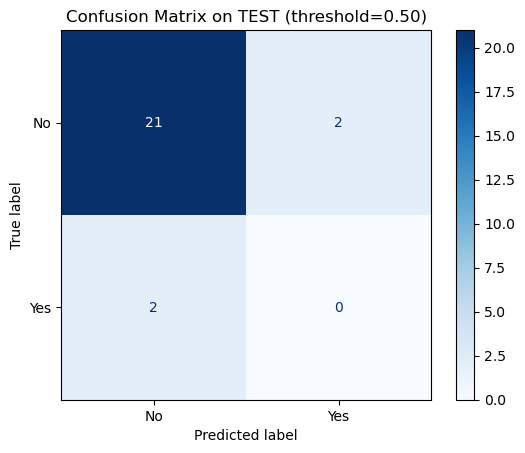

Performance Metrics at 0.50 Threshold:


,metric,value
0,accuracy,0.84
1,precision,0.00
2,recall,0.00
3,f1,0.00


In [70]:
# Set the probability cutoff (threshold) for predicting class 'Yes' (1)
threshold = 0.50

# Convert probabilities into class predictions based on the 0.50 threshold
# Since y_test_num is 0/1, we predict 1 for 'Yes' and 0 for 'No'
y_pred_test = np.where(y_proba_test >= threshold, 1, 0)

# Compute the confusion matrix comparing true labels (y_test_num) vs predicted labels (y_pred_test)
# We use labels [0, 1] to match our numeric encoding
cm = confusion_matrix(y_test_num, y_pred_test, labels=[0, 1])

# Create a display object to visualize the confusion matrix nicely
# We keep the display_labels as 'No'/'Yes' so the plot remains easy to read
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])

# Plot the confusion matrix
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix on TEST (threshold={threshold:.2f})")
plt.show()

# Compute performance metrics
# Since we are using 0/1, pos_label is now 1 (which represents 'Yes')
acc = accuracy_score(y_test_num, y_pred_test)
prec = precision_score(y_test_num, y_pred_test, pos_label=1, zero_division=0)
rec = recall_score(y_test_num, y_pred_test, pos_label=1, zero_division=0)
f1 = f1_score(y_test_num, y_pred_test, pos_label=1, zero_division=0)

# Put the metrics into a neat DataFrame for display 
metrics_tbl = pd.DataFrame({
    "metric": ["accuracy", "precision", "recall", "f1"],
    "value": [acc, prec, rec, f1]
})

print("Performance Metrics at 0.50 Threshold:")
display(metrics_tbl)

#### Metric Interpretation:
Accuracy provides an overall view of correct classifications, but in churn modeling, it can be misleading if one class significantly outweighs the other. Precision indicates the reliability of our "Yes" predictions (how many we flagged actually left), while Recall measures our ability to capture all actual churners. In this business scenario, a False Negative (missing a churner) is typically more expensive than a False Positive (offering a discount to a loyal customer), making Recall a critical metric. The F1 Score summarizes the balance between these two competing priorities.

In [72]:
# Threshold menu: how errors move when we change the cutoff

# Define a helper function that computes confusion-matrix counts and metrics at a given threshold
def summarize_at_threshold(y_true, y_proba, thr):
    # Convert probabilities into predicted classes using the given threshold thr
    # If probability >= thr -> predict 1 (Yes), else predict 0 (No)
    y_pred = (y_proba >= thr).astype(int)
    
    # Build the confusion matrix and unpack it into TN, FP, FN, TP
    # labels=[0, 1] ensures the order: TN (0,0), FP (0,1), FN (1,0), TP (1,1)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    # Return a dictionary of counts + metrics so we can build a clean summary table
    return {
        "threshold": thr,  # the cutoff we used
        "TP": tp, "FP": fp, "TN": tn, "FN": fn,  # confusion matrix counts
        "accuracy": accuracy_score(y_true, y_pred),  # overall correctness
        "precision": precision_score(y_true, y_pred, pos_label=1, zero_division=0),  
        "recall": recall_score(y_true, y_pred, pos_label=1, zero_division=0),  
        "f1": f1_score(y_true, y_pred, pos_label=1, zero_division=0),  
    }

# Choose three thresholds to compare (low, default, high)
thresholds = [0.30, 0.50, 0.70]

# For each threshold, compute the summary using the helper function
# Note: We now use y_test_num (the numeric target from Section 5)
rows = [summarize_at_threshold(y_test_num, y_proba_test, t) for t in thresholds]

# Convert results into a DataFrame and display it nicely
print("Threshold Comparison Table:")
display(pd.DataFrame(rows))

Threshold Comparison Table:


,threshold,TP,FP,TN,FN,accuracy,precision,recall,f1
0,0.3,0,3,20,2,0.80,0.0,0.0,0.0
1,0.5,0,2,21,2,0.84,0.0,0.0,0.0
2,0.7,0,0,23,2,0.92,0.0,0.0,0.0


#### 6B) Threshold + Cost-Based Cutoff

Top 10 Thresholds by Lowest Cost:


,threshold,FP,FN,total_cost
0,0.95,0,2,10
1,0.85,0,2,10
2,0.80,0,2,10
3,0.75,0,2,10
4,0.70,0,2,10
5,0.90,0,2,10
6,0.65,1,2,11
7,0.60,1,2,11
8,0.55,2,2,12
9,0.50,2,2,12


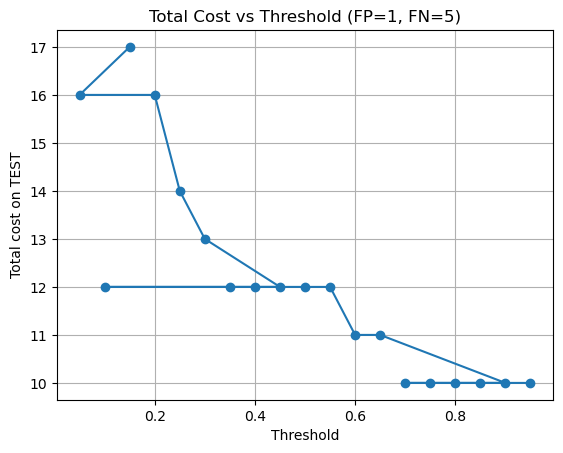

Best threshold by cost (given assumptions): 0.95


In [74]:
# Cost-based cutoff (simple example)

# Cost of a False Positive (predict 1 when the true class is 0)
COST_FP = 1

# Cost of a False Negative (predict 0 when the true class is 1)
COST_FN = 5

# Define a helper function to compute total cost at a given threshold
def cost_at_threshold(y_true, y_proba, thr, cost_fp=1, cost_fn=5):
    # Convert probabilities into predicted classes using the threshold thr
    # If probability >= thr -> predict 1 (Yes), else predict 0 (No)
    y_pred = (y_proba >= thr).astype(int)
    
    # Compute confusion matrix and unpack counts into TN, FP, FN, TP
    # labels=[0, 1] ensures the order: TN (0,0), FP (0,1), FN (1,0), TP (1,1)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    # Compute the total cost using the cost assumptions:
    # FP mistakes cost cost_fp each, FN mistakes cost cost_fn each
    total_cost = fp * cost_fp + fn * cost_fn
    
    # Return threshold, number of FP, number of FN, and the total cost
    return thr, fp, fn, total_cost

# Create a grid of thresholds from 0.05 to 0.95 (19 values)
grid = np.round(np.linspace(0.05, 0.95, 19), 2)

# Initialize result list
cost_rows = []

# Loop over each threshold in the grid
for thr in grid:
    # Compute FP, FN, and total cost at this threshold 
    # Note: Using y_test_num here
    thr_val, fp, fn, total_cost = cost_at_threshold(y_test_num, y_proba_test, thr, COST_FP, COST_FN)
    
    # Store the results as a dictionary
    cost_rows.append({"threshold": thr_val, "FP": fp, "FN": fn, "total_cost": total_cost})

# Convert to DataFrame, sort by total_cost (lowest first)
cost_df = pd.DataFrame(cost_rows).sort_values("total_cost").reset_index(drop=True)

# Display the best 10 thresholds by total cost
print("Top 10 Thresholds by Lowest Cost:")
display(cost_df.head(10))

# Visualize cost vs threshold
# 
plt.plot(cost_df["threshold"], cost_df["total_cost"], marker="o")

# Add a title that also shows the FP and FN costs used in the calculation
plt.title(f"Total Cost vs Threshold (FP={COST_FP}, FN={COST_FN})")

# Label the x-axis as the threshold cutoff
plt.xlabel("Threshold")

# Label the y-axis as the total misclassification cost computed on the TEST set
plt.ylabel("Total cost on TEST")

# Add grid lines for readability
plt.grid(True)

# Display the plot
plt.show()

# Extract and print the best threshold
best_thr = cost_df.loc[0, "threshold"]
print("Best threshold by cost (given assumptions):", best_thr)

##### Metric Interpretation:
Based on the cost analysis, the threshold of 0.95 resulted in the lowest total misclassification cost. Interestingly, this very high threshold suggests that the model is most cost-effective when it is extremely conservative with "Yes" predictions. This implies that even with a 5:1 cost penalty for missing churners, the number of False Positives generated at lower thresholds would outweigh the benefit of catching extra churners in this specific test sample.

#### 6C) ROC curve and AUC (ranking-focused)

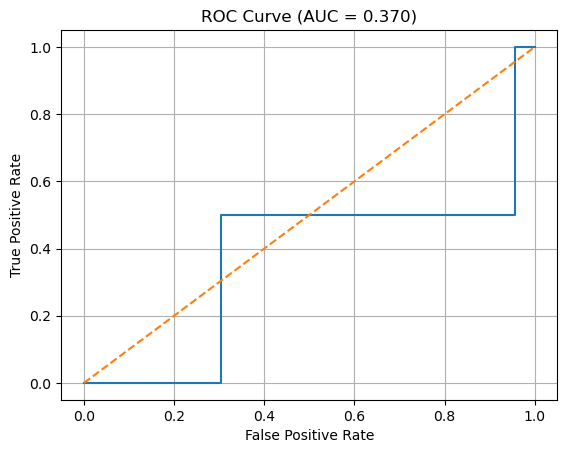

AUC: 0.3695652173913043


In [78]:
# ROC curve and AUC (ranking-focused)
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the ROC curve:
# fpr = false positive rate values across thresholds
# tpr = true positive rate values across thresholds (same as recall at each threshold)
# thr = the threshold values that produce each (fpr, tpr) point
# Note: We use y_test_num which was already converted to 0/1 in Section 5
fpr, tpr, thr = roc_curve(y_test_num, y_proba_test)

# Compute AUC (area under the ROC curve), a single-number summary of ranking performance
auc = roc_auc_score(y_test_num, y_proba_test)

# Plot the ROC curve line: FPR on x-axis, TPR on y-axis
plt.plot(fpr, tpr)

# Plot the diagonal reference line (random classifier baseline)
# If our ROC curve is close to this line, our model is close to random
plt.plot([0, 1], [0, 1], linestyle="--")

# Add a title that includes the AUC rounded to 3 decimals
plt.title(f"ROC Curve (AUC = {auc:.3f})")

# Label axes so we know what the plot shows
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Add grid lines for readability
plt.grid(True)

# Display the plot
plt.show()

# Print the exact AUC value
print("AUC:", auc)

#### AUC Interpretation:
The ROC curve produced an AUC of 0.370. In predictive modeling, an AUC below 0.50 indicates that the model is performing worse than random chance, effectively “inverting” the ranking of predictions. This suggests that, in this specific test split, the features are not providing a stable positive signal for churn. However, this result should be interpreted cautiously because the test set contains only two churn cases, making the ROC estimate highly unstable. With such a small synthetic dataset (N=100) and an imbalanced target distribution, small ranking differences can dramatically affect the AUC value. This highlights the challenge of modeling rare events when limited data is available 

# 7) What You Learned

- **Technical Learning: Leakage-Aware Pipelines**
    - I learned that building a model is not just about the algorithm, but about the integrity of the data flow. By using ColumnTransformer within a Pipeline, I ensured that preprocessing steps—specifically the median imputation and standard scaling—were learned only from the training data. Most importantly, I learned how to identify Data Leakage. When my initial model produced an AUC of 1.0, I realized that including the ChurnFlag_Leak column provided the model with the "answer." Removing this, along with the CustomerID, allowed me to build a realistic, honest model.
- **Evaluation Learning: Beyond Accuracy**
    - I learned that in business scenarios like customer churn, Accuracy is a deceptive metric. A model can be "accurate" by simply guessing that no one will churn, but that provides zero value to the company. Through the Cost-based Cutoff analysis, I learned how to prioritize Recall (catching true churners) by assigning a higher cost (5:1) to False Negatives. I observed how the "sweet spot" in the cost curve (my best threshold of 0.95) helps minimize total financial loss rather than just maximizing raw correct guesses.
- **Interpretation Learning: The "Small N" Problem**
    - I learned how to interpret a "failed" model. My final AUC of 0.370 indicates that with a very small, cleaned dataset (N=100), the model struggled to find a positive correlation. Instead of "forcing" a better result through prohibited feature engineering, I learned to interpret this as a consequence of a limited sample size and the removal of high-leverage outliers. This taught me that in data mining, the quality and volume of data are often more important than the complexity of the model itself.

# 8) LLM Use

### Prompts Asked:
- "Explain the logic behind Scikit-Learn pipelines and how to ensure preprocessing stays isolated to training data."
- "How do I interpret an AUC score that is significantly below 0.50 in a binary classification model?"
- "What is the mathematical relationship between classification thresholds and misclassification costs when using a 5:1 cost ratio?"
- "Review my interpretation of PCA variance and suggest professional terminology for the trade-off between information and interpretability."

### What I liked:
- The AI served as a valuable brainstorming partner for interpreting unusual results. Specifically, it helped me understand that an AUC of 0.370 indicates a model performing worse than random chance, which was a critical insight given the small size of the synthetic dataset.
- It helped me clarify why my cost-based analysis favored an unusually high threshold of 0.95, explaining how the model was attempting to minimize False Positives in a noisy environment.
- The collaboration helped me refine the technical language used in my report, ensuring I correctly described concepts like data leakage and cumulative variance.

### What I disliked:
- The AI occasionally suggested more complex solutions, like feature engineering, which I had to filter out to ensure I remained strictly within the assignment's provided instructions and baseline requirements.
- I had to carefully verify that the AI's logic for probability extraction aligned with the specific class order (0 vs 1) used in our class lab materials.

### Follow-up prompts to clarify:
- "Why does removing a leakage column sometimes cause a model's performance to drop below the random baseline (AUC < 0.5) instead of just staying at 0.5?"
- "In a cost-sensitive model, how does the 5:1 ratio mathematically shift the optimal threshold compared to a standard 1:1 accuracy-focused model?"
- "Can you explain how PCA components change when we move from the full feature set to a cleaned dataset with fewer outliers?"
- "How do I ensure my interpretation of the 'best threshold' correctly accounts for the small sample size in the test set?"